### Imports

In [407]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

# Visual overview

In [408]:
# load data
df = pd.read_csv('results.csv')
df.head()

,Age,English level,Education Level,Computing Experience,Task,Selected Answer,Correct,Case Type,Time Taken (ms),Submission Timestamp
0,23,esl,undergraduate,advanced,monitor cpu usage,monitor-cpu-usage,True,kebab,26919,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
1,23,esl,undergraduate,advanced,install software package,installSoftwarePackage,True,camel,20836,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
2,23,esl,undergraduate,advanced,manage firewall rules,manageFirewallRules,True,camel,16048,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
3,23,esl,undergraduate,advanced,backup database files,backupDatabaseFiles,True,camel,9786,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...
4,23,esl,undergraduate,advanced,configure network interface,configureNetworkInterface,True,camel,9116,Tue Dec 03 2024 17:47:56 GMT+0000 (Coordinated...


In [409]:
# prepate Timestamp field
df['Submission Timestamp'] = pd.to_datetime(df['Submission Timestamp'], format='%a %b %d %Y %H:%M:%S GMT%z (Coordinated Universal Time)')

# count unique users (Age, English level, Education Level, Computing Experience and Submission Timestamp should be the same)
df['user'] = df['Age'].astype(str) + df['English level'] + df['Education Level'] + df['Computing Experience'] + df['Submission Timestamp'].astype(str)
df['user'] = df['user'].apply(lambda x: hash(x))
df['user'] = df['user'].astype(str)
print('Unique users:', len(df['user'].unique()))

Unique users: 21


In [410]:
number_of_tests_per_user = df.shape[0] / df['user'].nunique()
print('Number of tests per user:', int(number_of_tests_per_user))

Number of tests per user: 30


---

### Outliers check

In [411]:
df_test = df.copy()
# Sort by time taken
df_test = df_test.sort_values(by='Time Taken (ms)', ascending=False)
df_test = df_test.reset_index(drop=True)
# Top 5 unique slowest users
df_test.head(5)

,Age,English level,Education Level,Computing Experience,Task,Selected Answer,Correct,Case Type,Time Taken (ms),Submission Timestamp,user
0,16,efl,hs,moderate,monitor cpu usage,monitor-cpu-usage,True,kebab,52166,2024-12-03 19:47:32+00:00,-5163013596131270560
1,23,efl,undergraduate,moderate,monitor cpu usage,monitor-cpu-usage,True,kebab,43185,2024-12-03 17:58:41+00:00,-2038536704126433573
2,20,efl,undergraduate,advanced,monitor cpu usage,monitor-cpu-usage,True,kebab,40184,2024-12-12 16:53:07+00:00,-3655450482603961718
3,23,efl,undergraduate,moderate,run diagnostic tests,run-diagnostic-tests,True,kebab,28959,2024-12-03 17:58:41+00:00,-2038536704126433573
4,23,esl,undergraduate,advanced,monitor cpu usage,monitor-cpu-usage,True,kebab,26919,2024-12-03 17:47:56+00:00,6074148900123643700


*These users may have started the test without looking at the manuals*

In [412]:
df_test.tail(5)

,Age,English level,Education Level,Computing Experience,Task,Selected Answer,Correct,Case Type,Time Taken (ms),Submission Timestamp,user
625,19,efl,undergraduate,advanced,enable network settings,disableWokeSettings,False,camel,332,2024-12-03 21:53:55+00:00,7229947503828059969
626,19,efl,undergraduate,advanced,upload data to server,uploadDataTooSever,False,camel,299,2024-12-03 21:53:55+00:00,7229947503828059969
627,19,efl,undergraduate,advanced,compress large files,compress-lake-file,False,kebab,247,2024-12-03 21:53:55+00:00,7229947503828059969
628,19,efl,undergraduate,advanced,create user account,create-user-account,True,kebab,232,2024-12-03 21:53:55+00:00,7229947503828059969
629,19,efl,undergraduate,advanced,install software package,install-software-jacked,False,kebab,44,2024-12-03 21:53:55+00:00,7229947503828059969


*Such instantaneous responses could be indicative of choosing an answer at random*

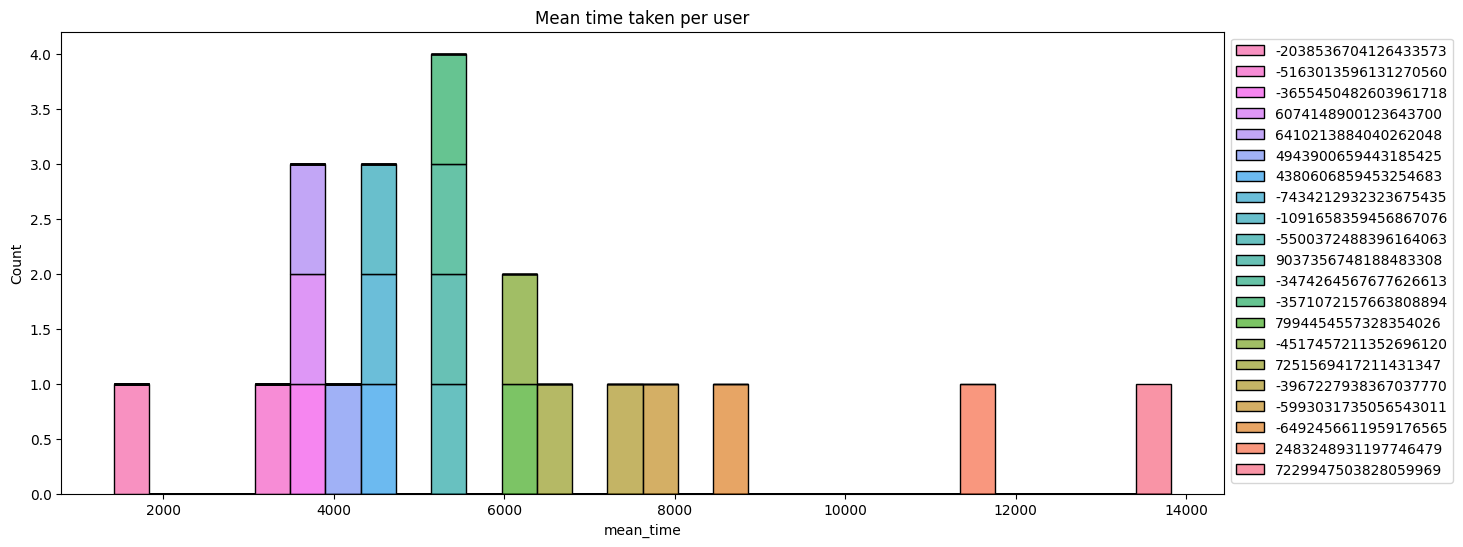

In [413]:
# display mean time taken for each user
df_mean = df.groupby('user').agg({'Time Taken (ms)': 'mean'}).reset_index()
df_mean.columns = ['user', 'mean_time']
df_mean = df_mean.sort_values(by='mean_time', ascending=False)

plt.figure(figsize=(15, 6))
sns.histplot(df_mean, x='mean_time', bins=30, hue='user', multiple='stack')
plt.title('Mean time taken per user')
plt.legend(df_mean['user'], bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


In [414]:
# remove outliers
df = df[df['user'] != '7229947503828059969']
df = df[df['user'] != '-2038536704126433573']
df = df[df['user'] != '-5163013596131270560']
df = df[df['user'] != '-3655450482603961718']
df = df[df['user'] != '6074148900123643700']

Although such a solution will cost as much as 23% of the data, but a closer look shows that the users were too irresponsible in their testing.

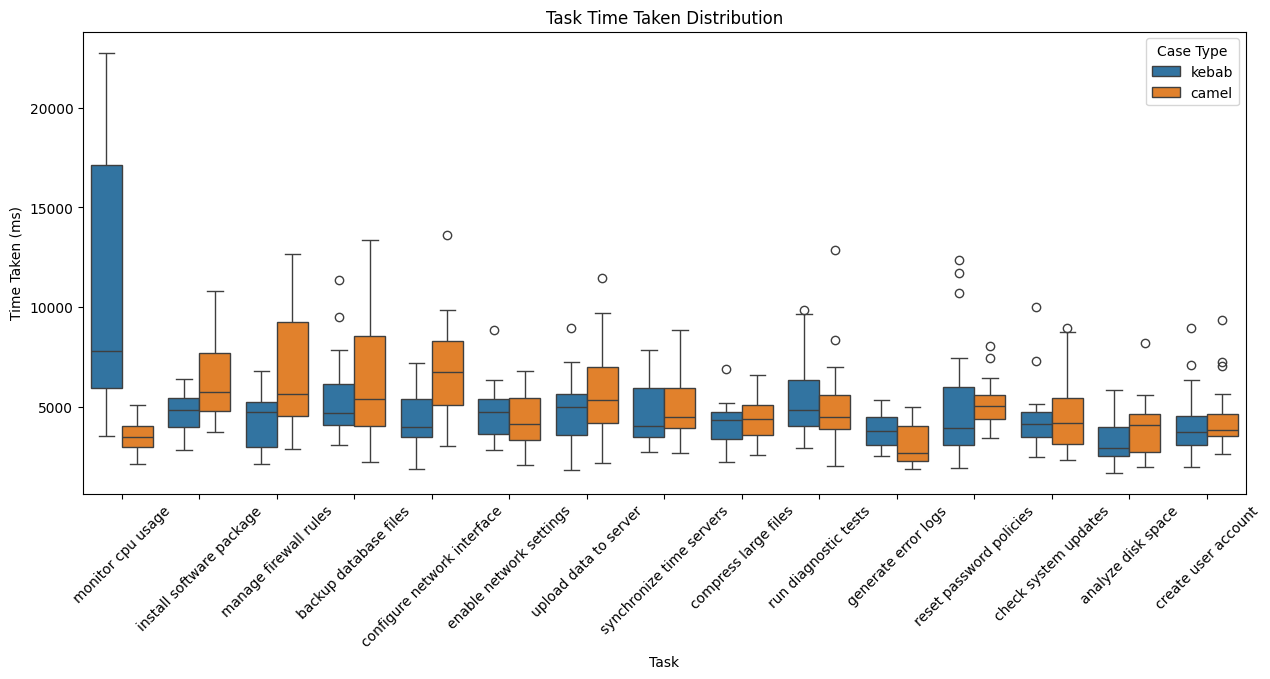

In [415]:
# Display Tasks with Case type and time taken (min, max, mean)
plt.figure(figsize=(15, 6))
sns.boxplot(x='Task', y='Time Taken (ms)', hue='Case Type', data=df)
plt.title('Task Time Taken Distribution')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

The stand out task is ‘Monitor CPU usage’, unfortunately this behaviour comes from the fact that in the kebab case it is the first task in the list of questions and when starting the test the tester could not understand what to do.

In [416]:
# remove the 'monitor cpu usage task'
df = df[df['Task'] != 'monitor cpu usage']

---

### Demographic data

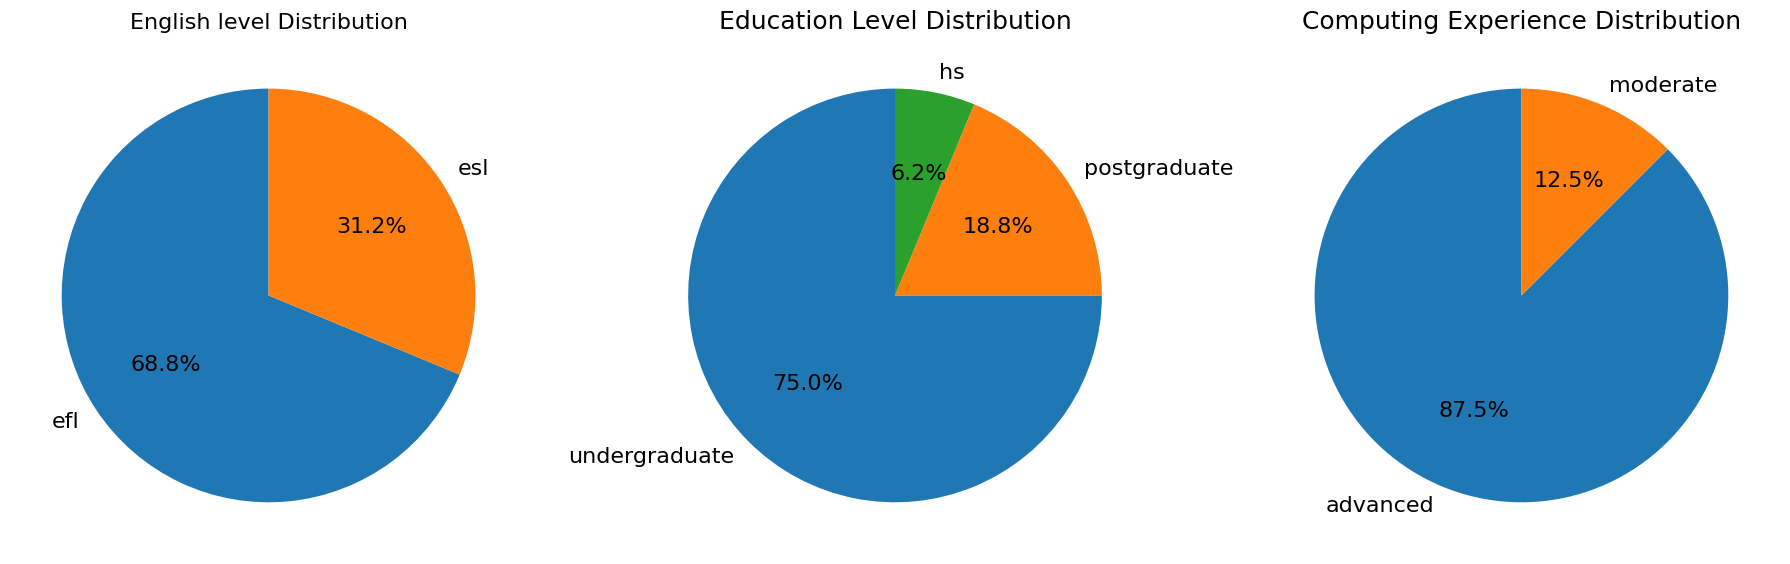

In [417]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

df['English level'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[0], textprops={'fontsize': 16})
axes[0].set_title('English level Distribution', fontsize=16)
axes[0].set_ylabel('')

df['Education Level'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[1], textprops={'fontsize': 16})
axes[1].set_title('Education Level Distribution', fontsize=18)
axes[1].set_ylabel('')

df['Computing Experience'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, ax=axes[2], textprops={'fontsize': 16})
axes[2].set_title('Computing Experience Distribution', fontsize=18)
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()


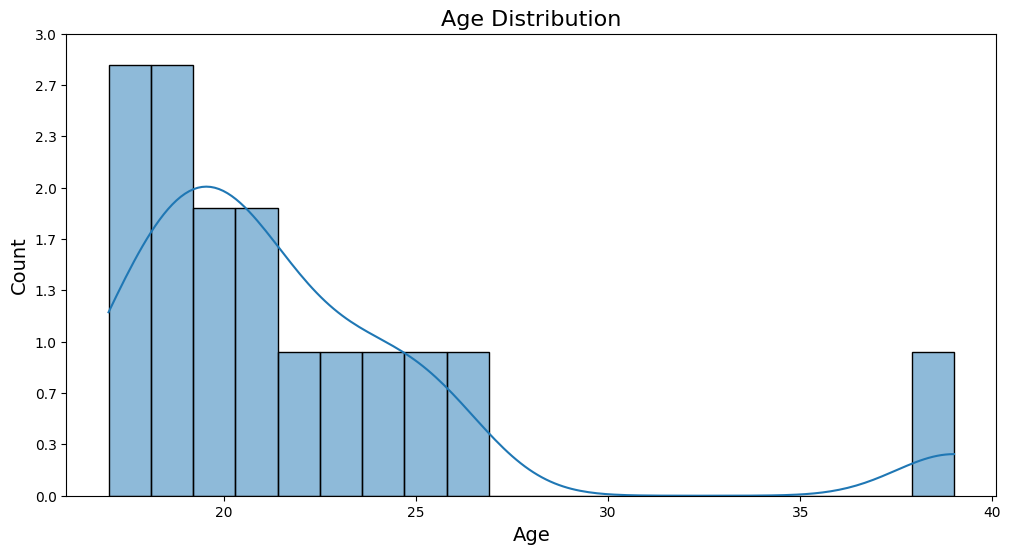

In [418]:
# Age distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['Age'], bins=20, kde=True)
y_vals = plt.gca().get_yticks()
plt.gca().set_yticks(y_vals)
plt.gca().set_yticklabels([f'{y / number_of_tests_per_user:.1f}' for y in y_vals])
plt.title('Age Distribution', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

---

### General for Case Type

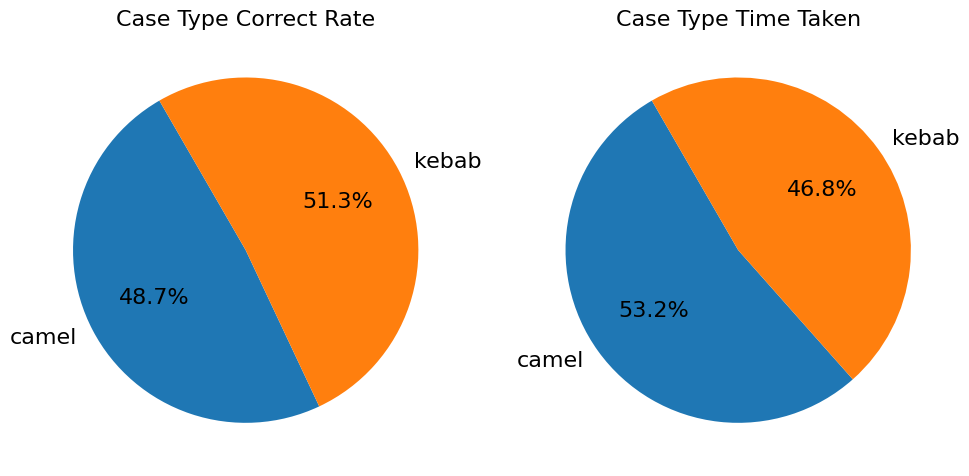

In [419]:
# Display Case type and their correct rate
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

df.groupby('Case Type')['Correct'].mean().plot.pie(autopct='%1.1f%%', startangle=120, ax=axes[0], textprops={'fontsize': 16})
axes[0].set_title('Case Type Correct Rate', fontsize=16)
axes[0].set_ylabel('')

df.groupby('Case Type')['Time Taken (ms)'].mean().plot.pie(autopct='%1.1f%%', startangle=120, ax=axes[1], textprops={'fontsize': 16})
axes[1].set_title('Case Type Time Taken', fontsize=16)
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


- This indicates that kebab case is slightly more accurate than camel case.
- Both case types require almost the same time, but kebab case is marginally faster.

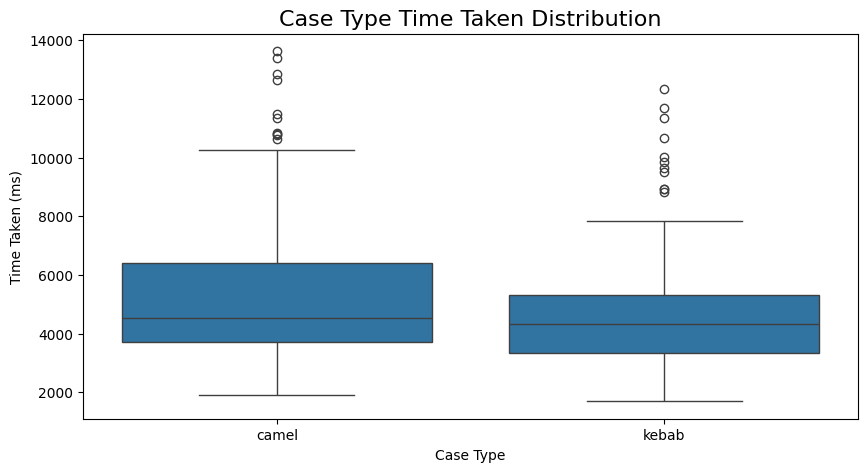

In [420]:
# Display Case type and their min, max, mean time taken
plt.figure(figsize=(10, 5))
sns.boxplot(x='Case Type', y='Time Taken (ms)', data=df)
plt.title('Case Type Time Taken Distribution', fontsize=16)
plt.show()

---

### Tasks

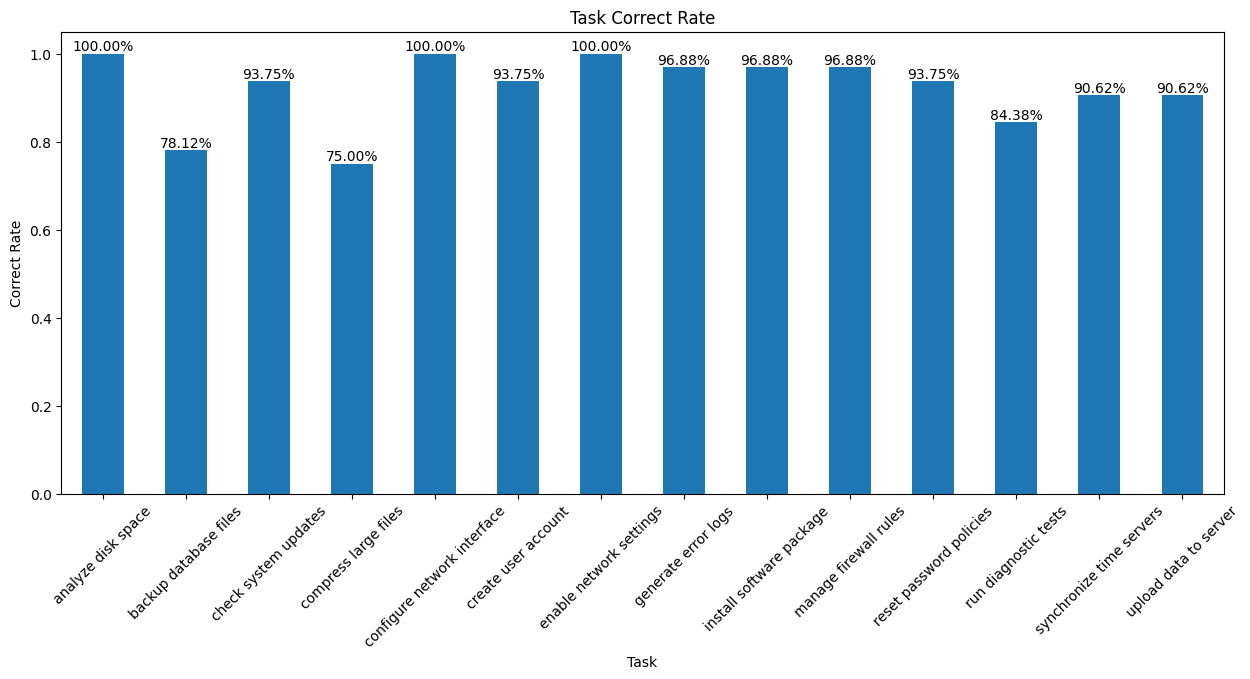

In [421]:
# Display Tasks and their correct rate
df['Correct'] = df['Correct'].astype(int)
plt.figure(figsize=(15, 6))
df.groupby('Task')['Correct'].mean().plot.bar()
plt.title('Task Correct Rate')
plt.xlabel('Task')
plt.ylabel('Correct Rate')
plt.xticks(rotation=45)

df_correct_rate = df.groupby('Task')['Correct'].mean()
for i, (task, rate) in enumerate(df_correct_rate.items()):
  plt.annotate(f'{rate:.2%}', xy=(i, rate), ha='center', va='bottom')

plt.show()

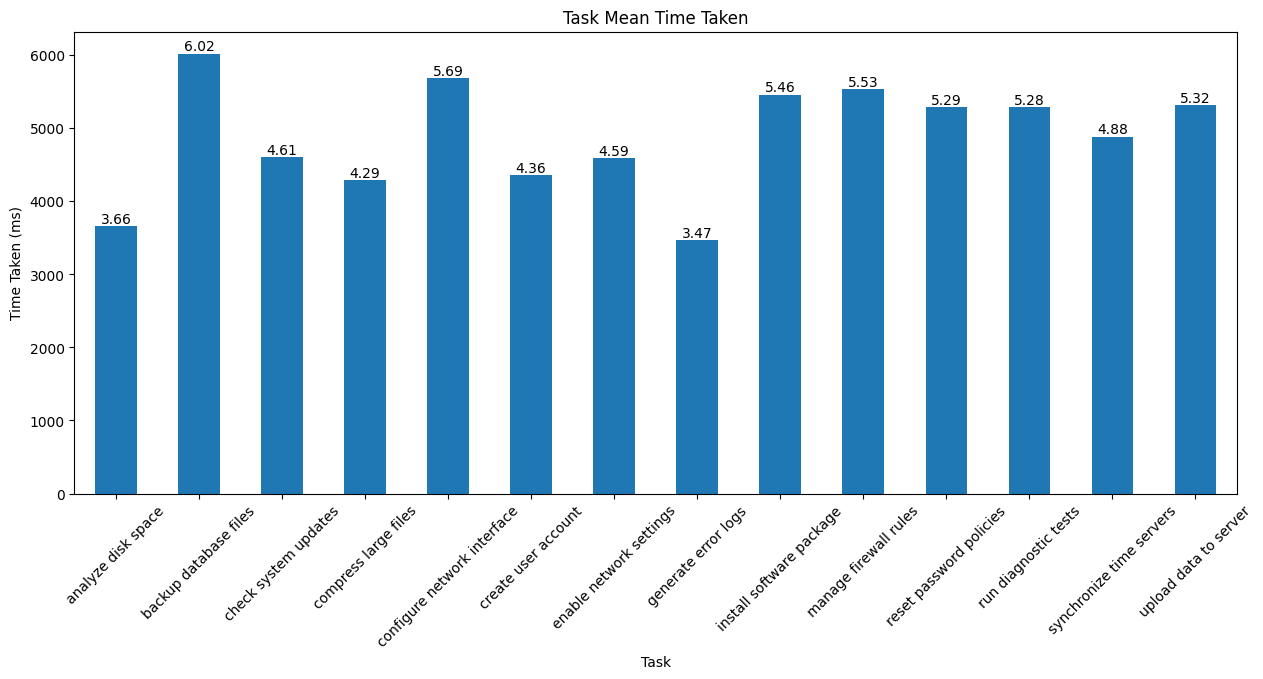

In [422]:
# Display Tasks and their time taken (ms)
plt.figure(figsize=(15, 6))
df.groupby('Task')['Time Taken (ms)'].mean().plot.bar()
plt.title('Task Mean Time Taken')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)

df_time_taken = df.groupby('Task')['Time Taken (ms)'].mean()
for i, (task, time) in enumerate(df_time_taken.items()):
  plt.annotate(f'{time / 1000:.2f}', xy=(i, time), ha='center', va='bottom')

plt.show()

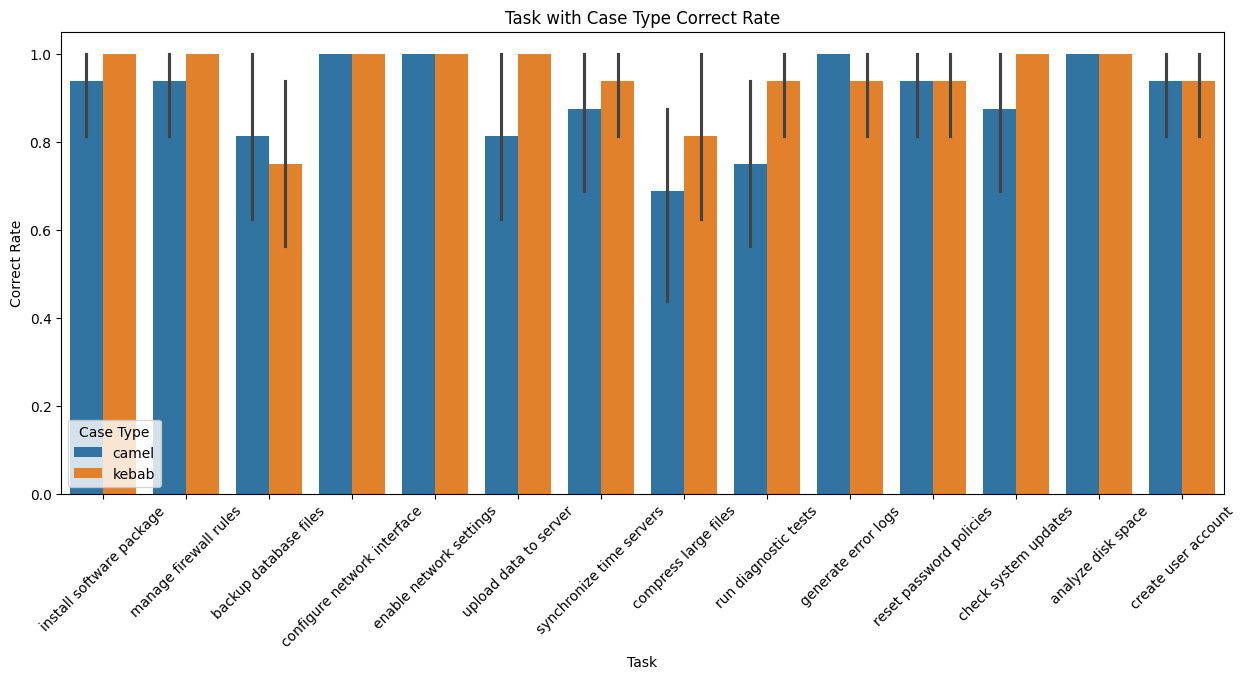

In [423]:
# Display Tasks with Case Type and their correct rate
plt.figure(figsize=(15, 6))
sns.barplot(x='Task', y='Correct', hue='Case Type', data=df)
plt.title('Task with Case Type Correct Rate')
plt.xlabel('Task')
plt.ylabel('Correct Rate')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

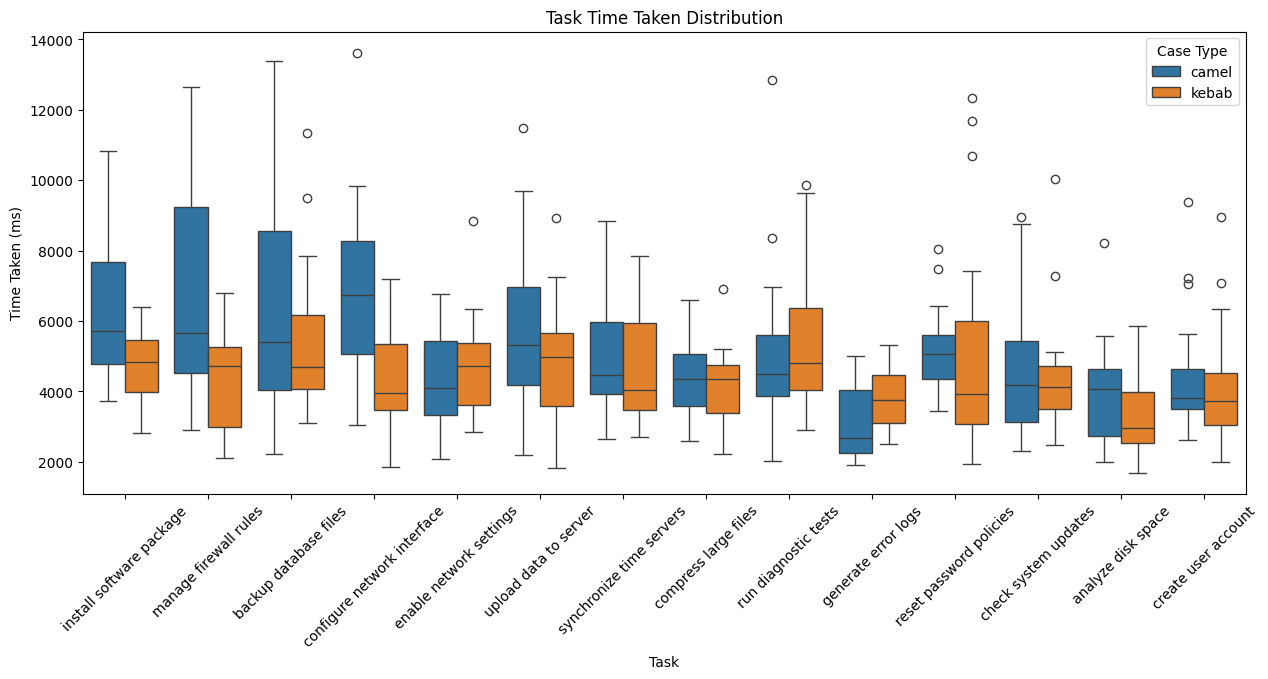

In [445]:
# Display Tasks with Case type and time taken (min, max, mean)
plt.figure(figsize=(15, 6))
sns.boxplot(x='Task', y='Time Taken (ms)', hue='Case Type', data=df)
plt.title('Task Time Taken Distribution')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

---

### Answers

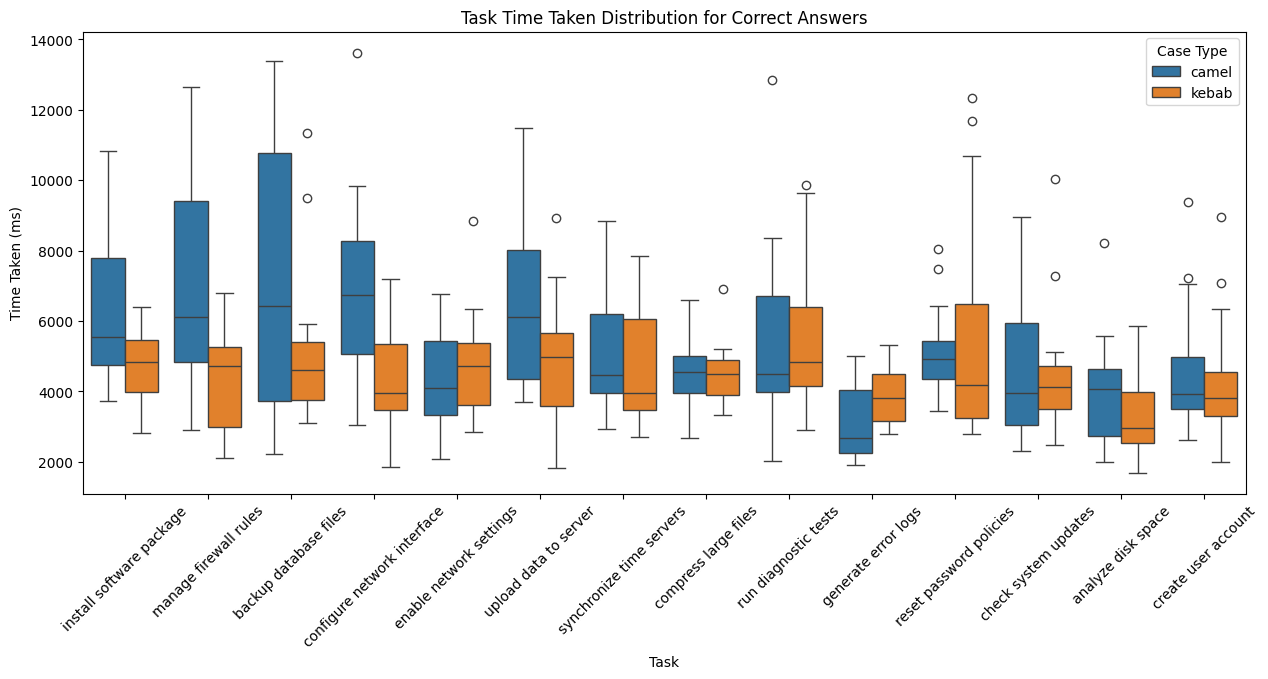

In [425]:
# Display Tasks with Case type and time taken (min, max, mean) but only for correct answers
plt.figure(figsize=(15, 6))
sns.boxplot(x='Task', y='Time Taken (ms)', hue='Case Type', data=df[df['Correct'] == 1])
plt.title('Task Time Taken Distribution for Correct Answers')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

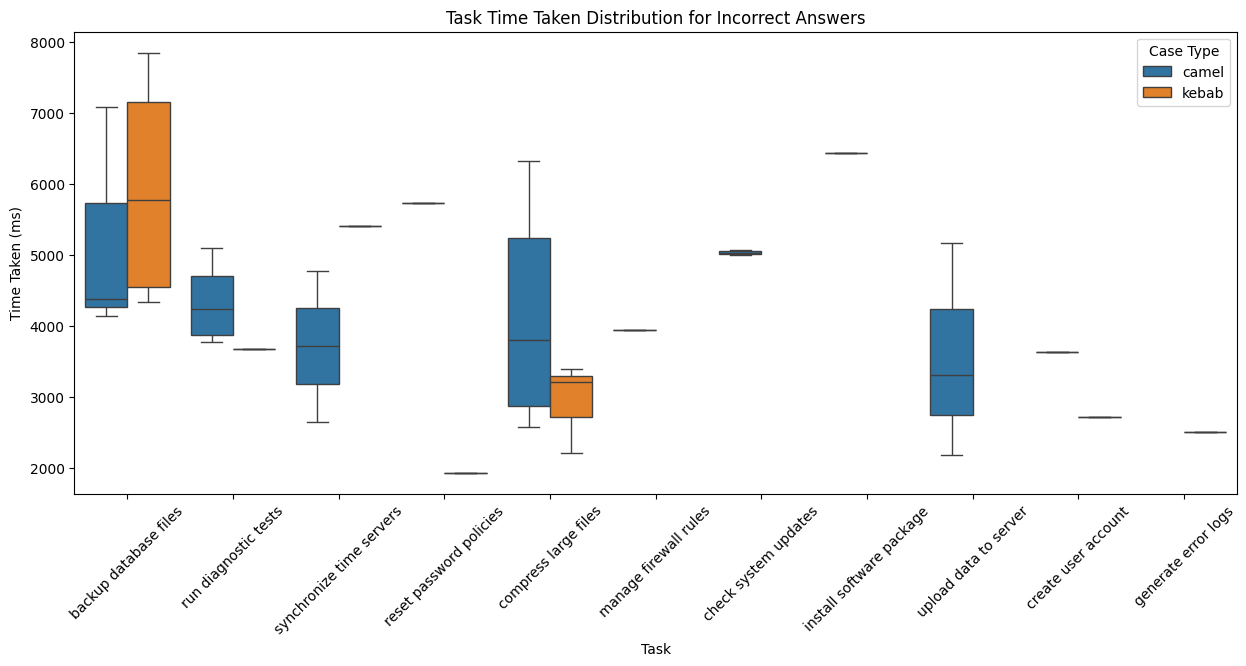

In [426]:
# Display Tasks with Case type and time taken (min, max, mean) but only for incorrect answers
plt.figure(figsize=(15, 6))
sns.boxplot(x='Task', y='Time Taken (ms)', hue='Case Type', data=df[df['Correct'] == 0])
plt.title('Task Time Taken Distribution for Incorrect Answers')
plt.xlabel('Task')
plt.ylabel('Time Taken (ms)')
plt.xticks(rotation=45)
plt.legend(title='Case Type')
plt.show()

---

### Demographic 

In [427]:
# demographics: 'Age', 'English level', 'Education Level', 'Computing Experience'

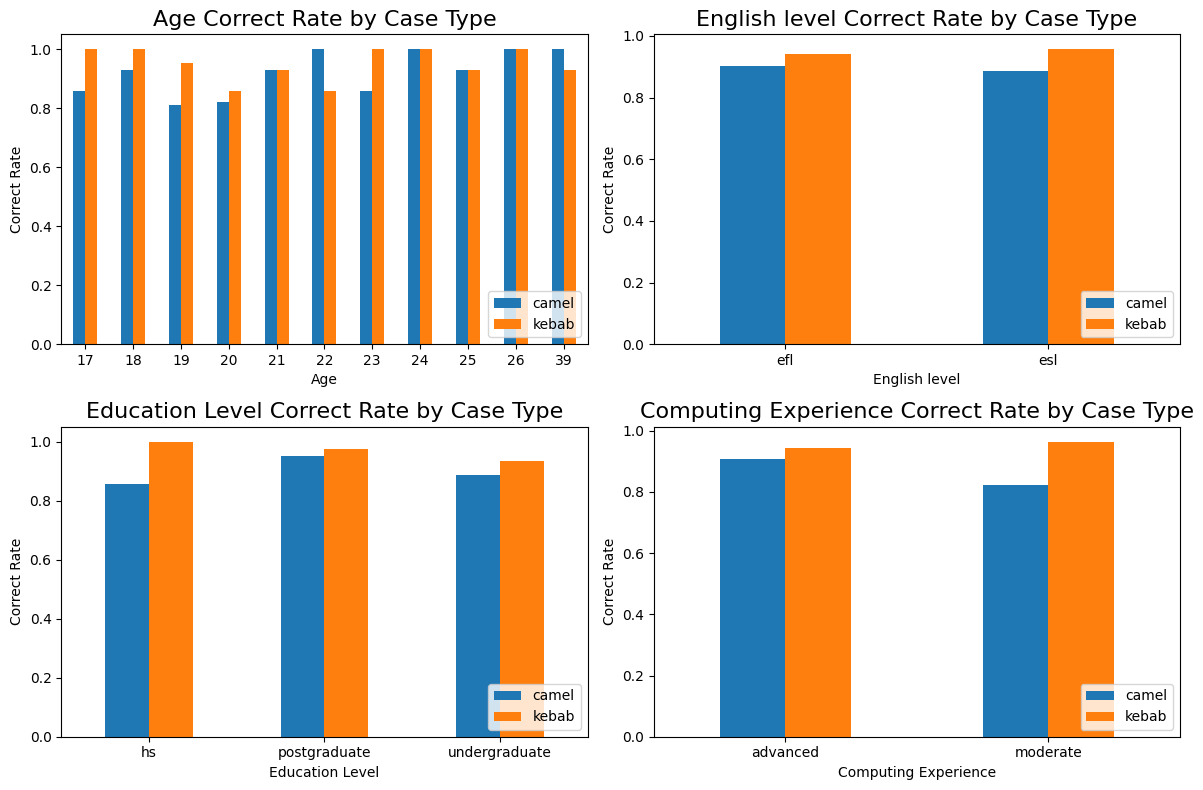

In [452]:
# Display distribution of Age, English level, Education Level, Computing Experience for correct rate
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df.groupby(['Age', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[0, 0])
axes[0, 0].set_title('Age Correct Rate by Case Type', fontsize=16)
axes[0, 0].set_ylabel('Correct Rate')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)
axes[0, 0].legend(loc='lower right')

df.groupby(['English level', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[0, 1])
axes[0, 1].set_title('English level Correct Rate by Case Type', fontsize=16)
axes[0, 1].set_ylabel('Correct Rate')
axes[0, 1].set_xlabel('English level')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)
axes[0, 1].legend(loc='lower right')

df.groupby(['Education Level', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[1, 0])
axes[1, 0].set_title('Education Level Correct Rate by Case Type', fontsize=16)
axes[1, 0].set_ylabel('Correct Rate')
axes[1, 0].set_xlabel('Education Level')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].legend(loc='lower right')

df.groupby(['Computing Experience', 'Case Type'])['Correct'].mean().unstack().plot.bar(ax=axes[1, 1])
axes[1, 1].set_title('Computing Experience Correct Rate by Case Type', fontsize=16)
axes[1, 1].set_ylabel('Correct Rate')
axes[1, 1].set_xlabel('Computing Experience')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.show()


Age:
- The correct rate is generally quite similar between kebab and camel case across different age groups, with kebab case performing slightly better on average, especially for ages 26 and 39.

English Level:
- For EFL (English as a Foreign Language), camel case has a slightly better correct rate than kebab case.
- For ESL (English as a Second Language), kebab case outperforms camel case.

Education Level:
- Postgraduate: Both case types have nearly identical performance.
- Undergraduate: Kebab case performs slightly better than camel case.
- High School (hs): Kebab case performs better than camel case in this category as well.

Computing Experience:
- Advanced: Camel case has a marginally higher correct rate.
- Moderate: Kebab case performs slightly better than camel case.

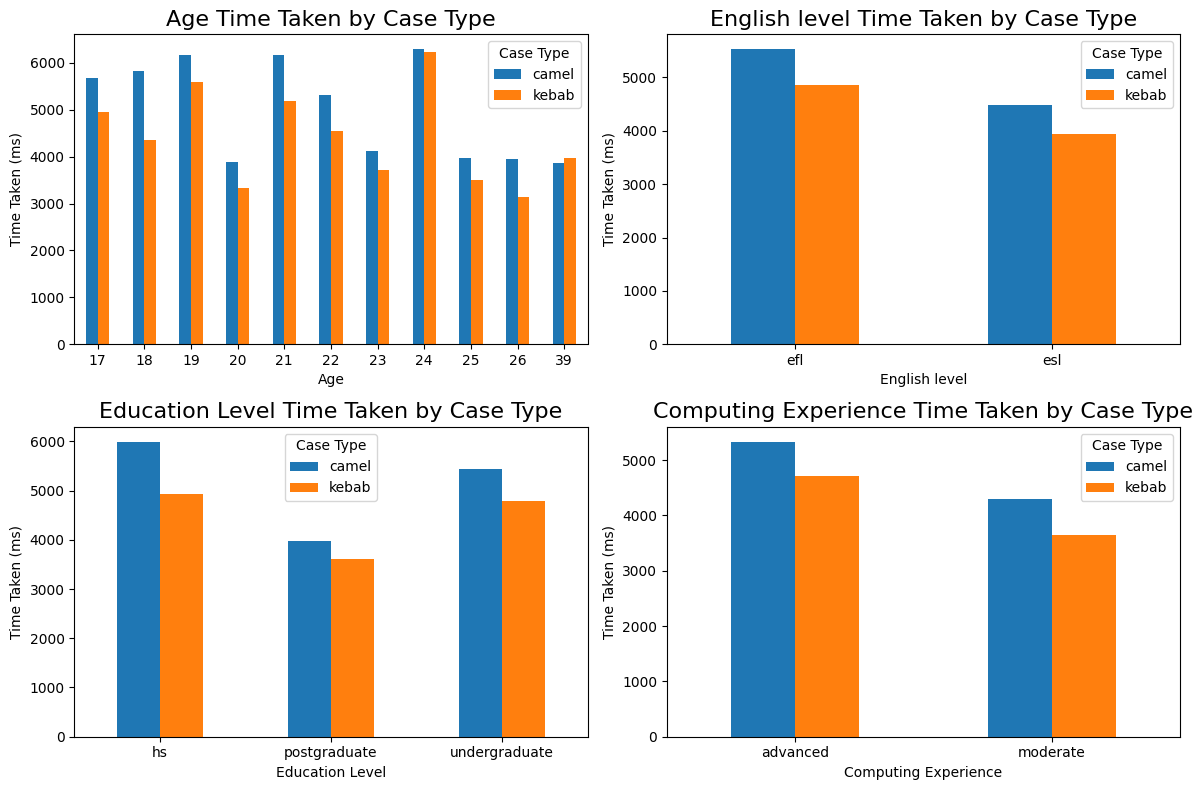

In [453]:
# Display distribution of Age, English level, Education Level, Computing Experience for time taken
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

df.groupby(['Age', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[0, 0])
axes[0, 0].set_title('Age Time Taken by Case Type', fontsize=16)
axes[0, 0].set_ylabel('Time Taken (ms)')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=0)

df.groupby(['English level', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[0, 1])
axes[0, 1].set_title('English level Time Taken by Case Type', fontsize=16)
axes[0, 1].set_ylabel('Time Taken (ms)')
axes[0, 1].set_xlabel('English level')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=0)

df.groupby(['Education Level', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[1, 0])
axes[1, 0].set_title('Education Level Time Taken by Case Type', fontsize=16)
axes[1, 0].set_ylabel('Time Taken (ms)')
axes[1, 0].set_xlabel('Education Level')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

df.groupby(['Computing Experience', 'Case Type'])['Time Taken (ms)'].mean().unstack().plot.bar(ax=axes[1, 1])
axes[1, 1].set_title('Computing Experience Time Taken by Case Type', fontsize=16)
axes[1, 1].set_ylabel('Time Taken (ms)')
axes[1, 1].set_xlabel('Computing Experience')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Age:
- For most age groups, kebab case takes less time than camel case, with the largest difference at age 24.

English Level:
- For EFL, camel case takes slightly more time than kebab case.
- For ESL, kebab case takes less time than camel case.

Education Level:
- Postgraduate: The time taken for both case types is quite close, with kebab case being slightly faster.
- Undergraduate: Kebab case also takes slightly less time than camel case.
- High School: Kebab case takes significantly less time than camel case.

Computing Experience:
- For advanced users, camel case takes more time, while for moderate users, kebab case takes less time.

---

# Descriptive Statistics

In [472]:
def format_discriptive(data):
  return data.map(lambda y: f'{y:.0f}' if y > 99 else f'{y:.2f}').map(lambda y: y.rstrip('0').rstrip('.') if '.' in y else y)

In [473]:
# Desciptive statistics for time taken
format_discriptive(df.groupby('Case Type')['Time Taken (ms)'].describe())

,count,mean,std,min,25%,50%,75%,max
Case Type,,,,,,,,
camel,224,5203,2339,1895,3707,4526,6422,13622
kebab,224,4574,1845,1695,3340,4322,5304,12340


In [474]:
# Desciptive statistics for correct rate
format_discriptive(df.groupby('Case Type')['Correct'].describe())

,count,mean,std,min,25%,50%,75%,max
Case Type,,,,,,,,
camel,224,0.9,0.3,0,1,1,1,1
kebab,224,0.95,0.23,0,1,1,1,1


In [475]:
# Desciptive statistics for time taken for each task
format_discriptive(df.groupby('Task')['Time Taken (ms)'].describe())

,count,mean,std,min,25%,50%,75%,max
Task,,,,,,,,
analyze disk space,32,3657,1453,1695,2620,3466,4338,8201
backup database files,32,6020,2921,2215,4059,4698,7328,13380
check system updates,32,4608,1950,2315,3444,4175,5048,10018
compress large files,32,4291,1155,2219,3372,4346,5010,6903
configure network interface,32,5685,2482,1847,3752,5308,6965,13622
create user account,32,4360,1829,1980,3442,3744,4513,9368
enable network settings,32,4589,1465,2091,3450,4480,5418,8839
generate error logs,32,3467,1009,1895,2633,3465,4390,5319
install software package,32,5458,1770,2817,4536,5140,6327,10819


In [476]:
# Desciptive statistics for demograhics
format_discriptive(df.groupby('Age')['Time Taken (ms)'].describe())

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
17,56,5311,1911,2117,4081,5063,6309,11472
18,28,5093,2319,2196,3392,4546,5960,10756
19,84,5875,2496,2685,4172,5056,6801,13380
20,56,3607,1273,1695,2706,3529,4344,7308
21,56,5676,2391,1966,4109,5078,7038,13622
22,28,4937,1723,1936,3814,4756,6296,8885
23,28,3915,1245,1706,3352,3877,4540,8024
24,28,6266,2077,3705,4916,6064,7108,12340
25,28,3739,1305,1897,2788,3634,4336,7451


In [477]:
format_discriptive(df.groupby(['English level', 'Case Type'])['Time Taken (ms)'].describe())

count  mean   std   min   25%   50%   75%    max
English level Case Type                                                 
efl           camel       154  5531  2501  1895  3812  4998  6774  13622
              kebab       154  4861  1998  1836  3419  4539  5533  12340
esl           camel        70  4480  1743  2033  3493  4248  4900  11472
              kebab        70  3944  1249  1695  3073  3742  4807   6903

In [478]:
format_discriptive(df.groupby(['Education Level', 'Case Type'])['Time Taken (ms)'].describe())

count  mean   std   min   25%   50%   75%    max
Education Level Case Type                                                 
hs              camel        14  5994  2325  3818  4331  4978  7493  11472
                kebab        14  4930  1139  3025  4010  5063  5505   6903
postgraduate    camel        42  3973  1170  2071  3170  4000  4540   8024
                kebab        42  3606  1038  1706  2969  3438  3952   6807
undergraduate   camel       168  5444  2461  1895  3734  4912  6664  13622
                kebab       168  4787  1972  1695  3462  4510  5476  12340

In [479]:
format_discriptive(df.groupby(['Computing Experience', 'Case Type'])['Time Taken (ms)'].describe())

count  mean   std   min   25%   50%   75%  \
Computing Experience Case Type                                             
advanced             camel       196  5333  2415  1895  3734  4638  6494   
                     kebab       196  4706  1888  1836  3378  4408  5446   
moderate             camel        28  4293  1443  2134  3408  4244  4773   
                     kebab        28  3653  1170  1695  2875  3629  4534   

                                  max  
Computing Experience Case Type         
advanced             camel      13622  
                     kebab      12340  
moderate             camel       8024  
                     kebab       6165

---

# Inferential Statistics

In [463]:
# Inferential Statistics for time taken
from scipy.stats import f_oneway, t

# ANOVA test for time taken by Case Type
case_type_c = df[df['Case Type'] == 'camel']['Time Taken (ms)']
case_type_k = df[df['Case Type'] == 'kebab']['Time Taken (ms)']

f_statistic, p_value = f_oneway(case_type_c, case_type_k)

print(f'ANOVA test for time taken by Case Type: F-statistic={f_statistic:.4f}, p-value={p_value:.4f}')

ANOVA test for time taken by Case Type: F-statistic=9.9754, p-value=0.0017


In [460]:
# Chi-square test for correct rate by Case Type
from scipy.stats import chisquare

case_type_c = df[df['Case Type'] == 'camel']['Correct']
case_type_k = df[df['Case Type'] == 'kebab']['Correct']

chi_statistic, p_value = chisquare([case_type_c.mean(), case_type_k.mean()])
print(f'Chi-square test for correct rate by Case Type: Chi-square={chi_statistic:.4f}, p-value={p_value:.2f}')

Chi-square test for correct rate by Case Type: Chi-square=0.0013, p-value=0.97


In [462]:
# T-test for time taken by Tasks
from scipy.stats import ttest_ind

tasks = [
  'analyze disk space', 'backup database files', 'check system updates', 'compress large files',
  'configure network interface', 'create user account', 'enable network settings', 'generate error logs',
  'install software package', 'manage firewall rules', 'reset password policies',
  'run diagnostic tests', 'synchronize time servers', 'upload data to server'
]

results = []

for i in range(len(tasks)):
  task_c = df[(df['Task'] == tasks[i]) & (df['Case Type'] == 'camel')]['Time Taken (ms)']
  task_k = df[(df['Task'] == tasks[i]) & (df['Case Type'] == 'kebab')]['Time Taken (ms)']
  t_statistic, p_value = ttest_ind(task_c, task_k)
  results.append([tasks[i], tasks[i], t_statistic, p_value])

results = pd.DataFrame(results, columns=['Camel Case', 'Kebab Case', 'T-statistic', 'p-value'])
results = results.sort_values(by='p-value')
results = results.reset_index(drop=True)
results

,Camel Case,Kebab Case,T-statistic,p-value
0,configure network interface,configure network interface,3.537120,0.001338
1,manage firewall rules,manage firewall rules,2.906766,0.006805
2,install software package,install software package,2.729668,0.010505
3,generate error logs,generate error logs,-2.210230,0.034860
4,upload data to server,upload data to server,1.341362,0.189870
5,analyze disk space,analyze disk space,1.310594,0.199940
6,backup database files,backup database files,1.018535,0.316568
7,enable network settings,enable network settings,-0.763839,0.450929
8,create user account,create user account,0.470848,0.641155
9,synchronize time servers,synchronize time servers,0.450722,0.655431


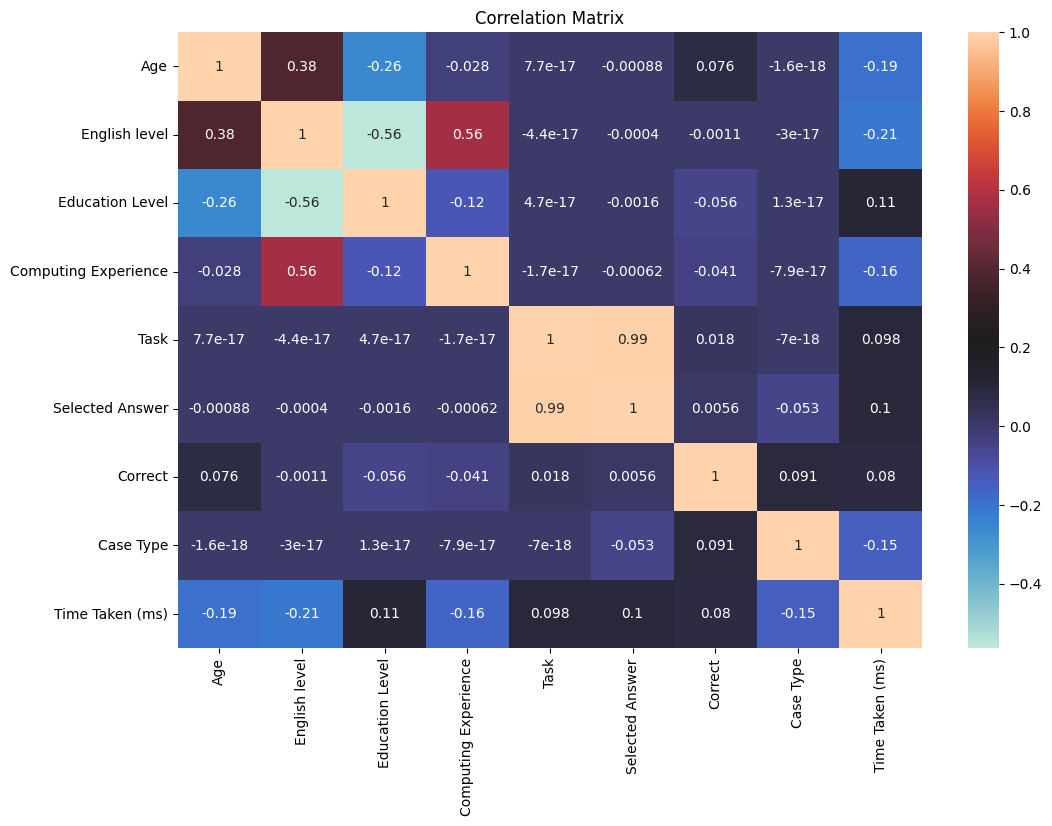

In [501]:
from sklearn.preprocessing import LabelEncoder
encoded_df = df.copy()

# Encode categorical columns
label_encoder = LabelEncoder()
encoded_df['English level'] = label_encoder.fit_transform(encoded_df['English level'])
encoded_df['Education Level'] = label_encoder.fit_transform(encoded_df['Education Level'])
encoded_df['Computing Experience'] = label_encoder.fit_transform(encoded_df['Computing Experience'])
encoded_df['Task'] = label_encoder.fit_transform(encoded_df['Task'])
encoded_df['Selected Answer'] = label_encoder.fit_transform(encoded_df['Selected Answer'])
encoded_df['Case Type'] = label_encoder.fit_transform(encoded_df['Case Type'])
encoded_df = encoded_df.drop(columns=['Submission Timestamp', 'user'])

# Display correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(encoded_df.corr(), annot=True, cmap='icefire')
plt.title('Correlation Matrix')
plt.show()

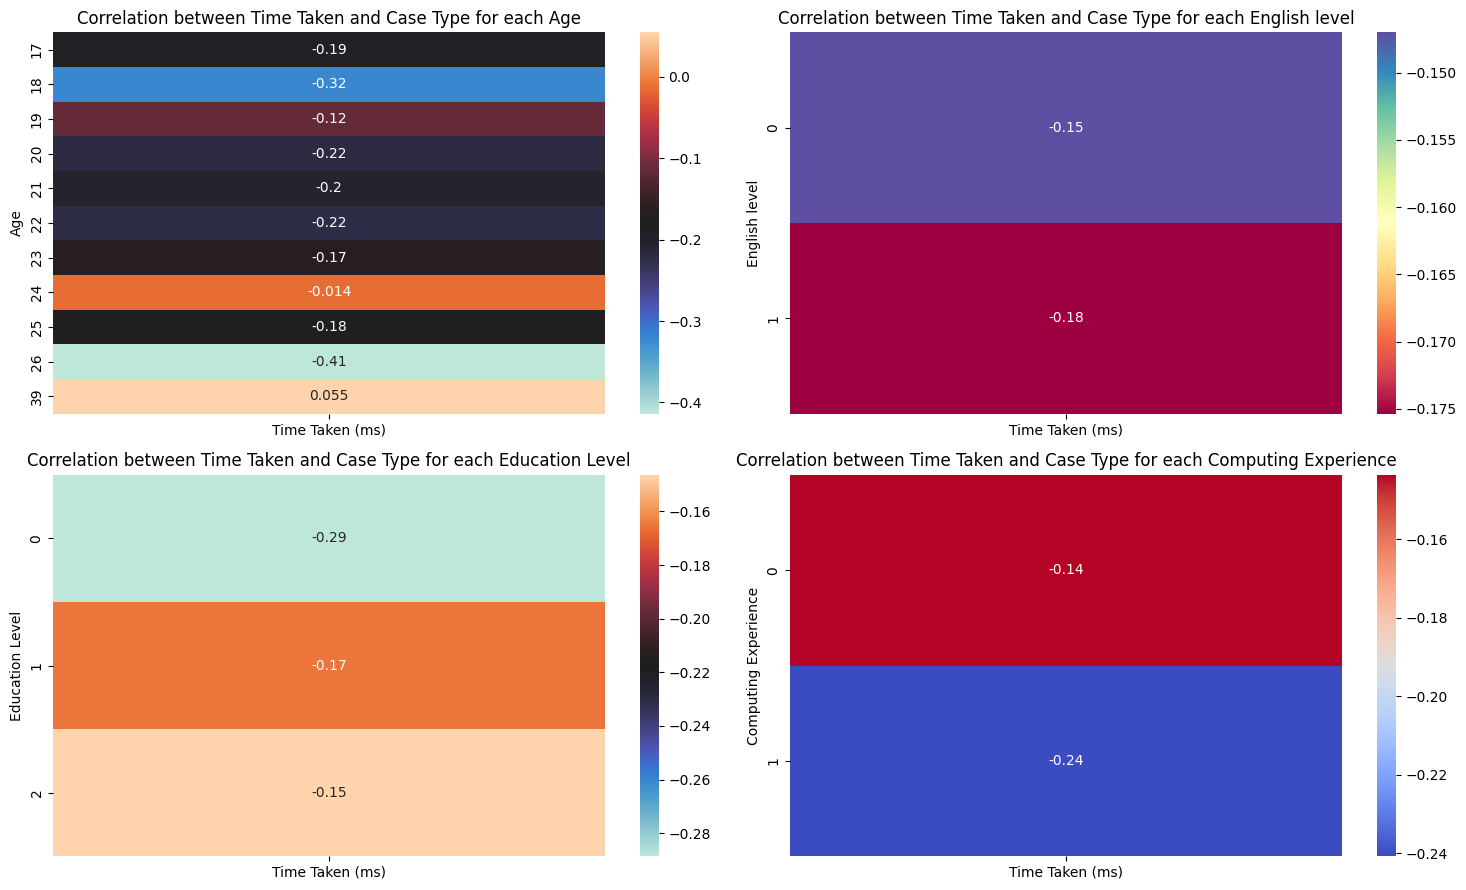

In [ ]:
# Calculate correlation for each Age
age_corr = encoded_df.groupby('Age')[['Time Taken (ms)', 'Case Type']].corr().iloc[0::2, 1].unstack()

# Calculate correlation for each English level
english_corr = encoded_df.groupby('English level')[['Time Taken (ms)', 'Case Type']].corr().iloc[0::2, 1].unstack()

# Calculate correlation for each Education Level
education_corr = encoded_df.groupby('Education Level')[['Time Taken (ms)', 'Case Type']].corr().iloc[0::2, 1].unstack()

# Calculate correlation for each Computing Experience
computing_corr = encoded_df.groupby('Computing Experience')[['Time Taken (ms)', 'Case Type']].corr().iloc[0::2, 1].unstack()

fig, axes = plt.subplots(2, 2, figsize=(15, 9))

# Plot heatmap for Age
sns.heatmap(age_corr, annot=True, cmap='icefire', ax=axes[0, 0])
axes[0, 0].set_title('Correlation between Time Taken and Case Type for each Age')

# Plot heatmap for English level
sns.heatmap(english_corr, annot=True, cmap='Spectral', ax=axes[0, 1])
axes[0, 1].set_title('Correlation between Time Taken and Case Type for each English level')

# Plot heatmap for Education Level
sns.heatmap(education_corr, annot=True, cmap='icefire', ax=axes[1, 0])
axes[1, 0].set_title('Correlation between Time Taken and Case Type for each Education Level')

# Plot heatmap for Computing Experience
sns.heatmap(computing_corr, annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Correlation between Time Taken and Case Type for each Computing Experience')

plt.tight_layout()
plt.show()

In [ ]:
encoded_df = encoded_df.drop(columns=['Task', 'Selected Answer'])

<Figure size 1200x600 with 0 Axes>

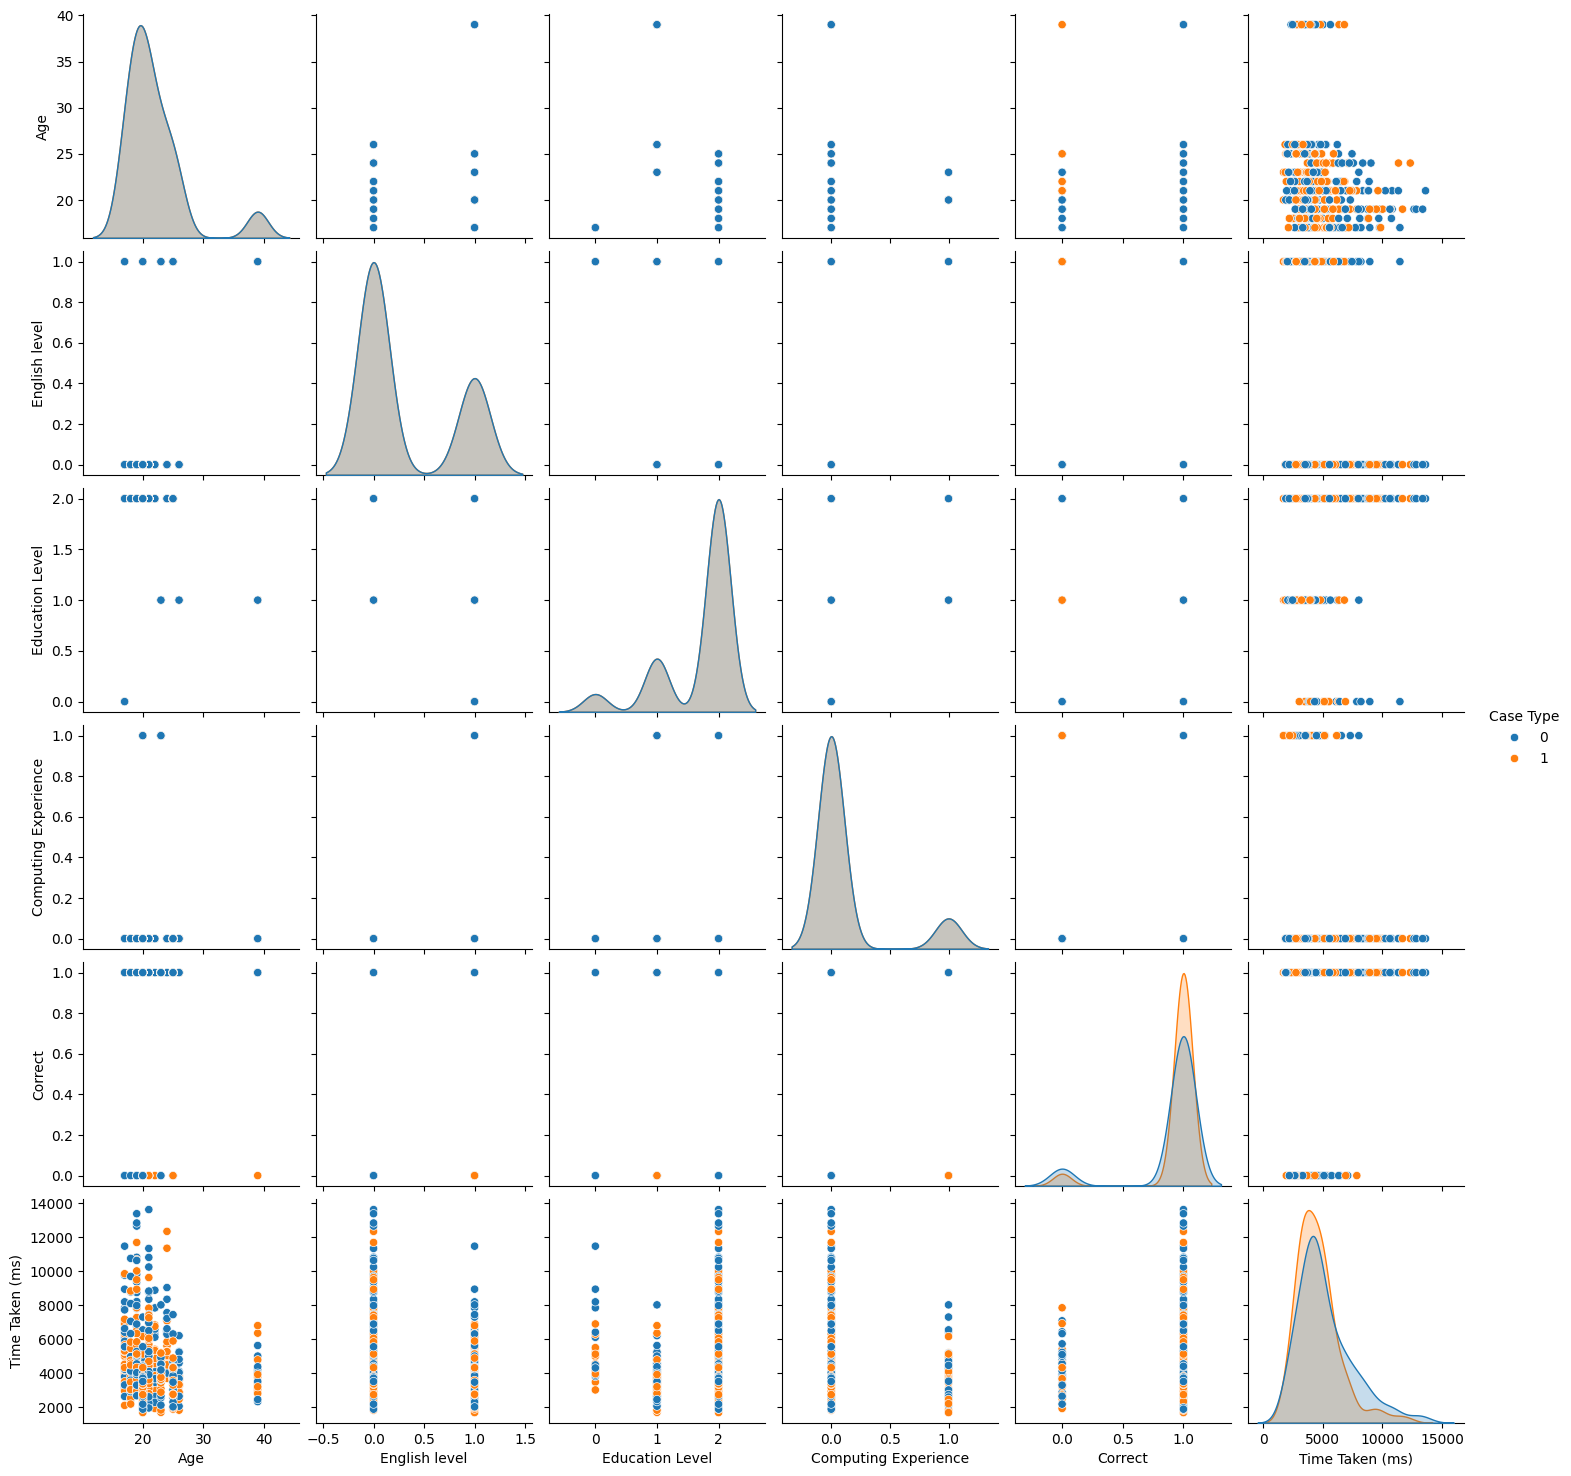

In [519]:
# pair plot 
plt.figure(figsize=(12, 6))
sns.pairplot(encoded_df, hue='Case Type')
plt.show()

Mean Squared Error: 0.26
              precision    recall  f1-score   support

           0       0.40      0.86      0.54        37
           1       0.44      0.08      0.13        53

    accuracy                           0.40        90
   macro avg       0.42      0.47      0.34        90
weighted avg       0.42      0.40      0.30        90



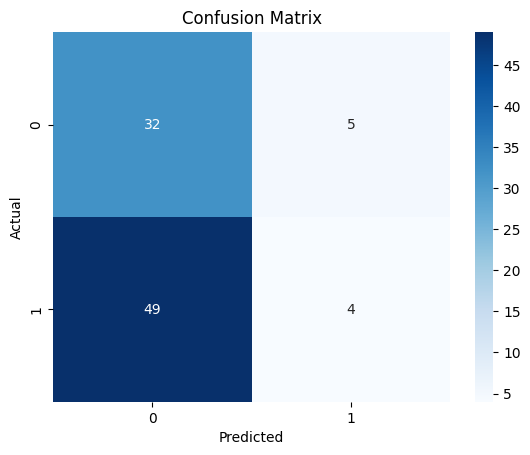

In [514]:
# Regression analysis
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix

# Prepare data
X = encoded_df[['Age', 'English level', 'Education Level', 'Computing Experience']]
y = encoded_df['Case Type']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# Classification report
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()